## Imports, GPU settings, and utility functions

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
from datasets import CINIC
from edsr import edsr
from trainer import EdsrTrainer
import tensorflow as tf


def show(x):
    display(Markdown(x))


def get_params(filename):
    params = {'filename': filename}
    splits = filename[:-5].split("_")
    params['dataset'] = splits[0]
    params['model'] = splits[1]
    params['lr_scale'] = int(splits[3][-1])
    params['hr_scale'] = int(splits[5][-1])
    params['nb_res'] = int(splits[7])
    params['nb_filt'] = int(splits[9])
    params['batch_size'] = int(splits[11])
    params['transform'] = splits[13] == "True"
    params['every'] = int(splits[15])
    params['steps'] = int(splits[17])
    model = edsr(scale=2, dataset=params['dataset'], nb_res=int(params['nb_res']), nb_filters=int(params['nb_filt']))
    params['nb_params'] = int(model.count_params())
    return params


def table(params):
    for param in params:
        with open(param['filename'], "r") as f:
            data = json.load(f)

        avg_time = np.mean(data['time'])
        avg_hr = np.rint(data['avg_hr_train_shape'][:2]).astype(np.int32)
        avg_lr = np.rint(data['avg_lr_train_shape'][:2]).astype(np.int32)
        hr_label = f"({avg_hr[1]}, {avg_hr[0]})"
        lr_label = f"({avg_lr[1]}, {avg_lr[0]})"

        dataset = param['filename'].split("_")[0].upper()
        psnr = np.amax(data['psnr'])
        loss = np.amin(data['losses'])
        nb_params = param['nb_params']
        print(r" & ".join([_ if isinstance(_, str) else f"{_:.2f}" for _ in [dataset, hr_label, lr_label, avg_time, psnr, loss, nb_params]]) + " \\\\")


def filter_params(params, sort=None, reverse=False, **kwargs):
    for key, val in kwargs.items():
        if isinstance(val, (str, int)):
            val = [val]
        params = [d for d in params if d[key] in val]
    if isinstance(sort, list):
        params = sorted(params, key=lambda x: tuple(x[s] for s in sort), reverse=reverse)
    elif sort:
        params = sorted(params, key=lambda x: x[sort], reverse=reverse)
    return params


def plot(params, field, savefile, title=None, xlabel=None, ylabel=None, label_type=["size"], upper=50, lower=0):
    plt.figure(figsize=(8, 5), dpi=300)
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    for param in params:
        with open(param["filename"], "r") as f:
            data = json.load(f)

        data[field] = np.array(data[field])
        lower_ind = lower < data[field]
        upper_ind = data[field] < upper
        ind = lower_ind == upper_ind
        data[field] = data[field][ind]
        labels = []
        if "size" in label_type:
            avg_hr = np.rint(data['avg_hr_train_shape'][:2]).astype(np.int32)
            avg_lr = np.rint(data['avg_lr_train_shape'][:2]).astype(np.int32)
            hr_label = f"({avg_hr[1]}, {avg_hr[0]}) avg. HR size"
            lr_label = f"({avg_lr[1]}, {avg_lr[0]}) avg. LR size"
            labels.extend([hr_label, lr_label])
        if "res" in label_type:
            labels.append(f"{param['nb_res']} residual blocks")
        if "filt" in label_type:
            labels.append(f"{param['nb_filt']} filters")

        label = ", ".join(labels)

        plt.plot(range(len(data[field])), data[field], label=param["filename"][:5].upper() + " - " + label)

    plt.legend()
    plt.savefig(savefile)

# Results
---
This notebook is intended to hold all code related to creating graphs needed for the project paper as well as some other baseline results.

## Testing Bicubic Upscaling
- Images have been downscaled to 128x128 for the low resolution dataset
- Then they were upscaled using the models and using bicubic
- This is the PSNR of the bicubic upscaling and the smallest model

In [2]:
def resolve(model, lr_batch):
    lr_batch = tf.cast(lr_batch, tf.float32)
    sr_batch = model(lr_batch)
    sr_batch = tf.clip_by_value(sr_batch, 0, 255)
    sr_batch = tf.round(sr_batch)
    sr_batch = tf.cast(sr_batch, tf.uint8)
    return sr_batch


def psnr(x1, x2):
    return tf.image.psnr(x1, x2, max_val=255)


def evaluate(dataset, model=None):
    psnr_values = []
    for lr, hr in dataset:
        if model:
            sr = resolve(model, lr)
        else:
            sr = lr

        sr_shape = tf.shape(sr)
        psnr_value = psnr(hr[:, :sr_shape[1], :sr_shape[2], :], sr)[0]
        psnr_values.append(psnr_value)
    return tf.reduce_mean(psnr_values)


valid_loader = CINIC(scale=1, subset="valid")

valid_ds, valid_shapes = valid_loader.dataset(
    batch_size=1, random_transform=False, repeat_count=1, upscale_lr=True
)
PSNR = evaluate(valid_ds).numpy()
show(f"**Bicubic PSNR** = {PSNR:.2f} dB")

valid_loader = CINIC(scale=1, subset="valid")

valid_ds, valid_shapes = valid_loader.dataset(
    batch_size=1, random_transform=False, repeat_count=1
)

trainer = EdsrTrainer(
    model=edsr(scale=2, dataset="cinic", nb_res=16, nb_filters=64),
    checkpoint_dir=f".ckpt/cinic-edsr-16-x1",
)
PSNR = evaluate(valid_ds, trainer.model).numpy()
show(f"**Baseline PSNR** = {PSNR:.2f} dB")

**Bicubic PSNR** = 29.24 dB

Model restored from checkpoint at step 274000.


**Baseline PSNR** = 30.64 dB

## Examples of Upscaled Images

In [3]:
valid_loader = CINIC(scale=1, subset="valid")

bicubic_ds, _ = valid_loader.dataset(
    batch_size=1, random_transform=False, repeat_count=1, upscale_lr=True
)

model_ds, _ = valid_loader.dataset(
    batch_size=1, random_transform=False, repeat_count=1
)
model = EdsrTrainer(
    model=edsr(scale=2, dataset="cinic", nb_res=16, nb_filters=64),
    checkpoint_dir=f".ckpt/cinic-edsr-16-x1",
).model

bicubics = [lr[0] for lr, hr in bicubic_ds]
models = []
real = []
for lr, hr in model_ds:
    models.append(resolve(model, lr)[0])
    real.append(hr[0])

Model restored from checkpoint at step 274000.


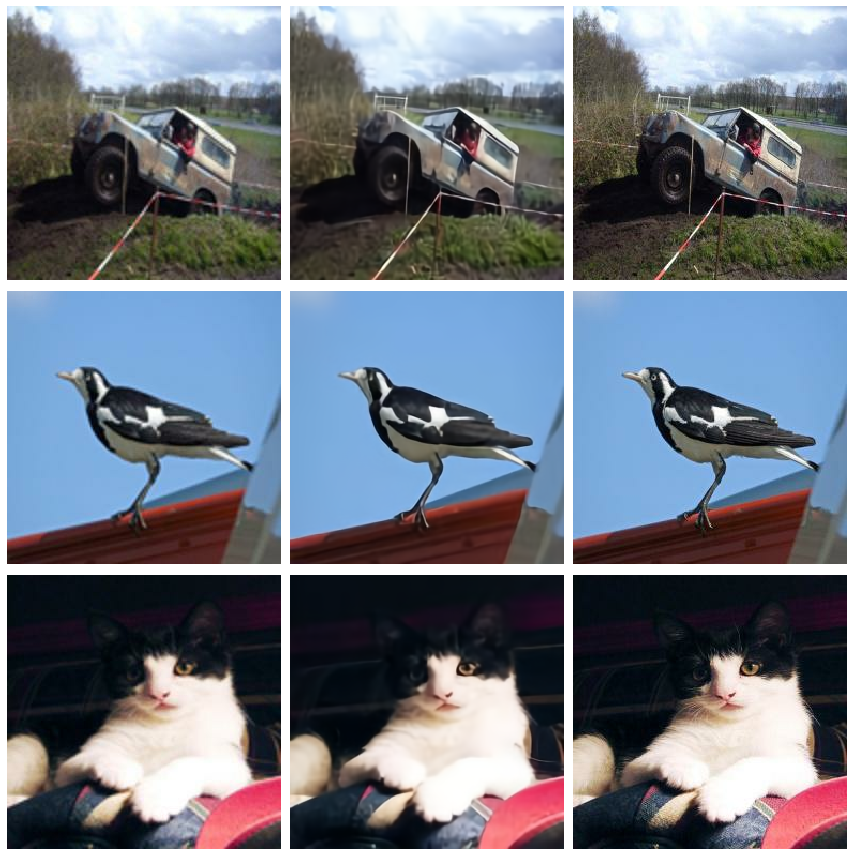

In [4]:
fig, ax = plt.subplots(3, 3)
fig.set_figheight(12)
fig.set_figwidth(12)
ind = [12, 21, 30]
b = [im for i, im in enumerate(bicubics) if i in ind]
m = [im for i, im in enumerate(models) if i in ind]
r = [im for i, im in enumerate(real) if i in ind]
for i, imgs in enumerate(zip(b, m, r)):
    for j, im in enumerate(imgs):
        ax[i][j].set_axis_off()
        ax[i][j].imshow(im)
fig.tight_layout()
plt.savefig("examples.png")

## DIV2K vs CINIC Baseline

In [5]:
import glob

experiments = glob.glob("*[0-9].json")
all_params = [get_params(experiment) for experiment in experiments]

DIV2K & (986, 718) & (493, 359) & 32.29 & 33.46 & 3.78 & 1369859.00 \\
DIV2K & (1972, 1435) & (986, 718) & 76.78 & 35.58 & 3.34 & 1369859.00 \\
DIV2K & (493, 359) & (246, 179) & 32.03 & 31.69 & 4.74 & 1369859.00 \\
CINIC & (128, 128) & (64, 64) & 32.13 & 30.64 & 7.28 & 1369859.00 \\
CINIC & (256, 256) & (128, 128) & 31.93 & 32.07 & 6.70 & 1369859.00 \\


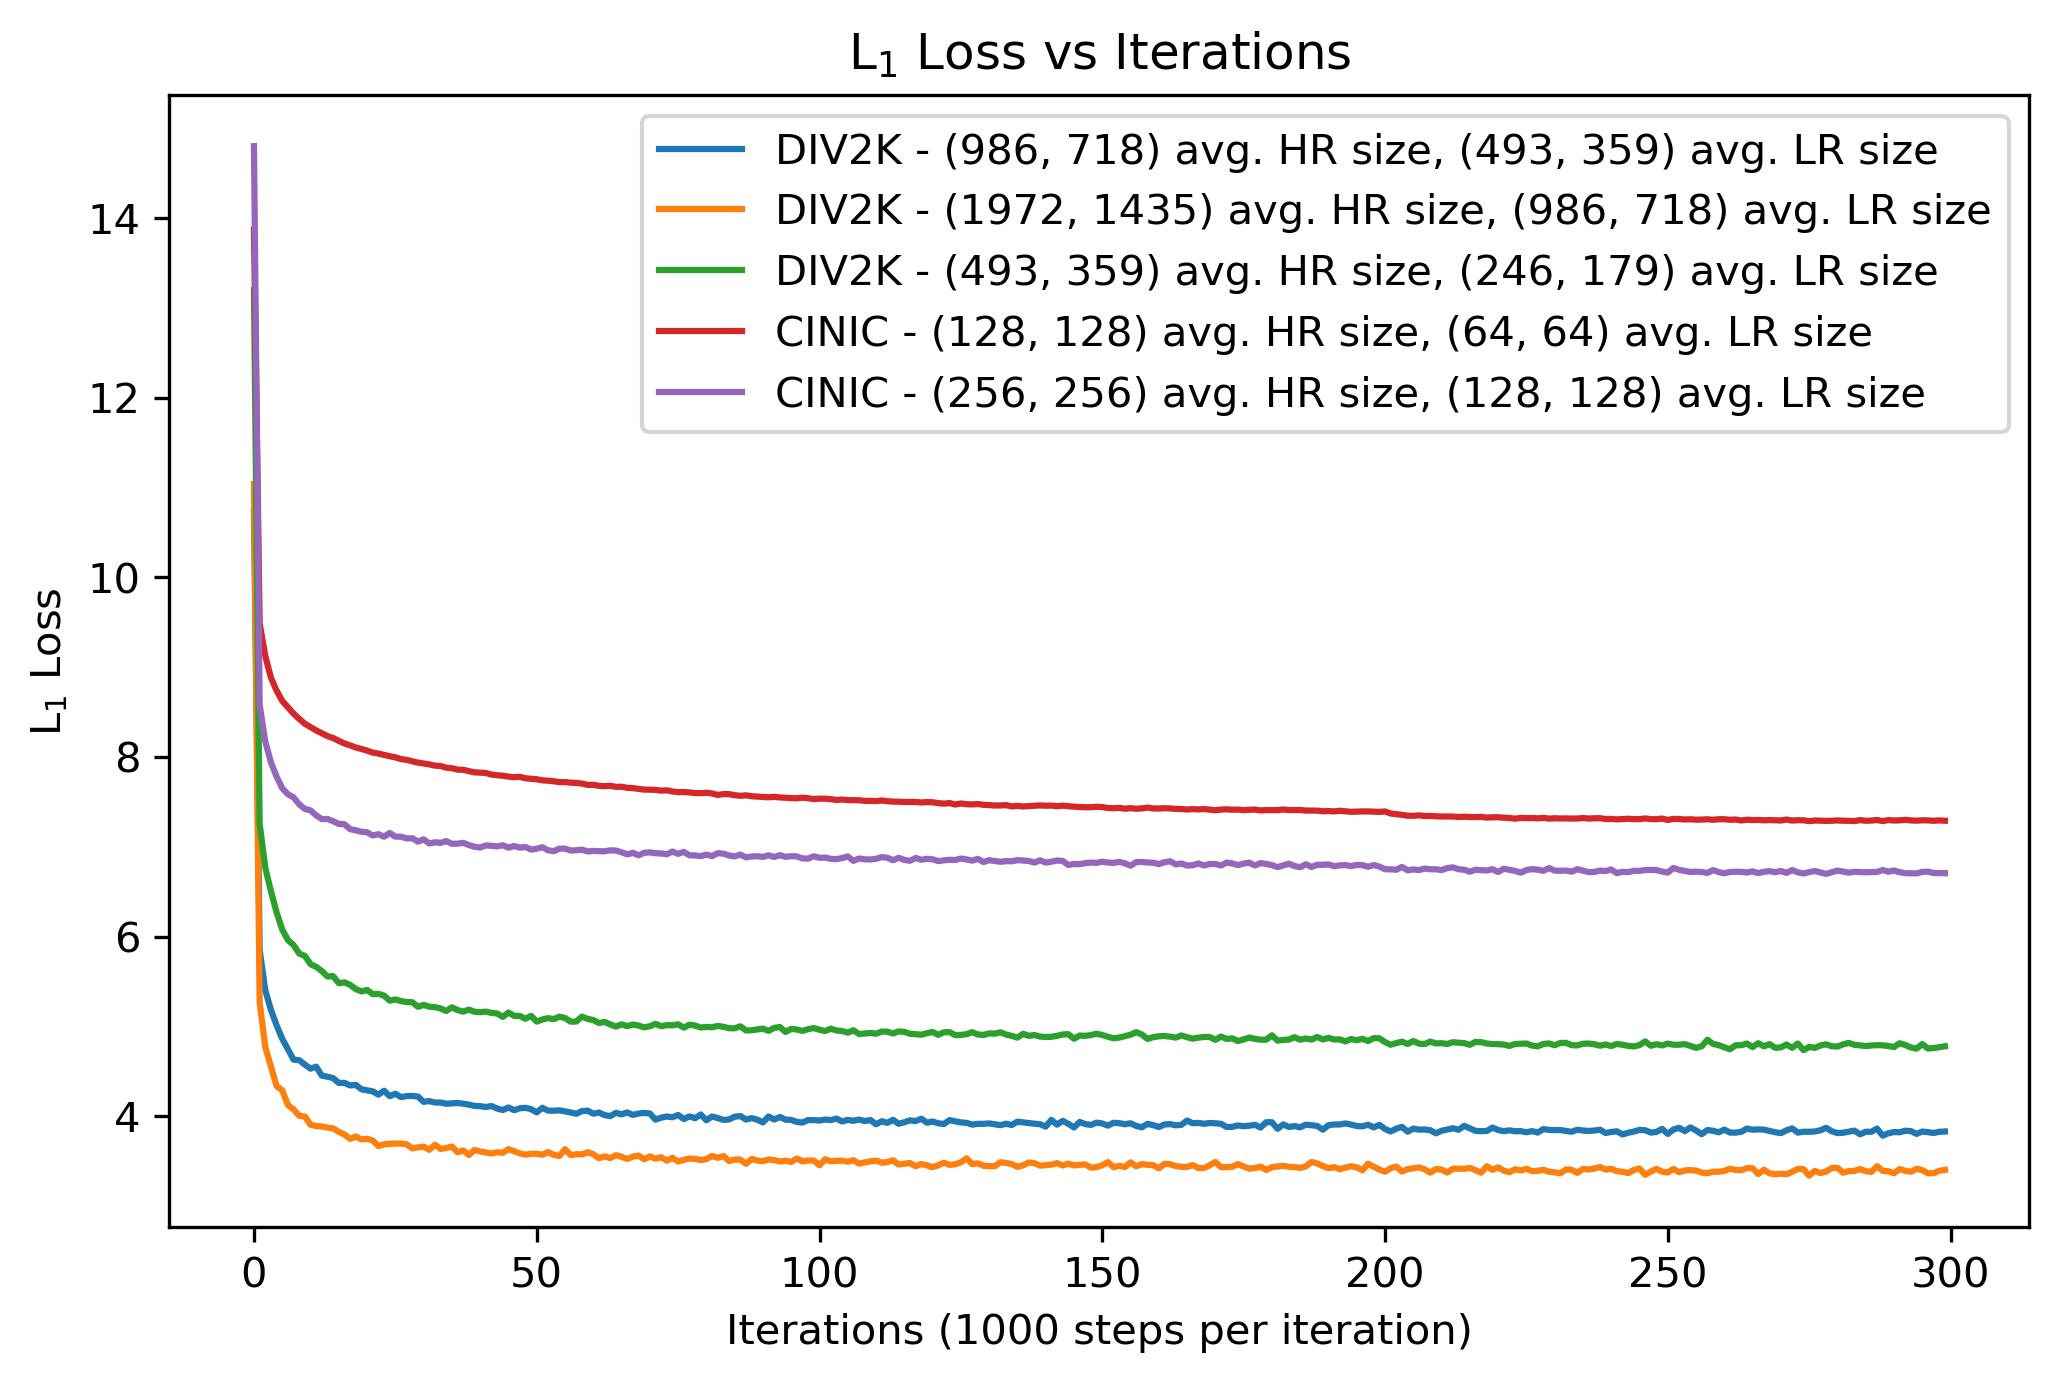

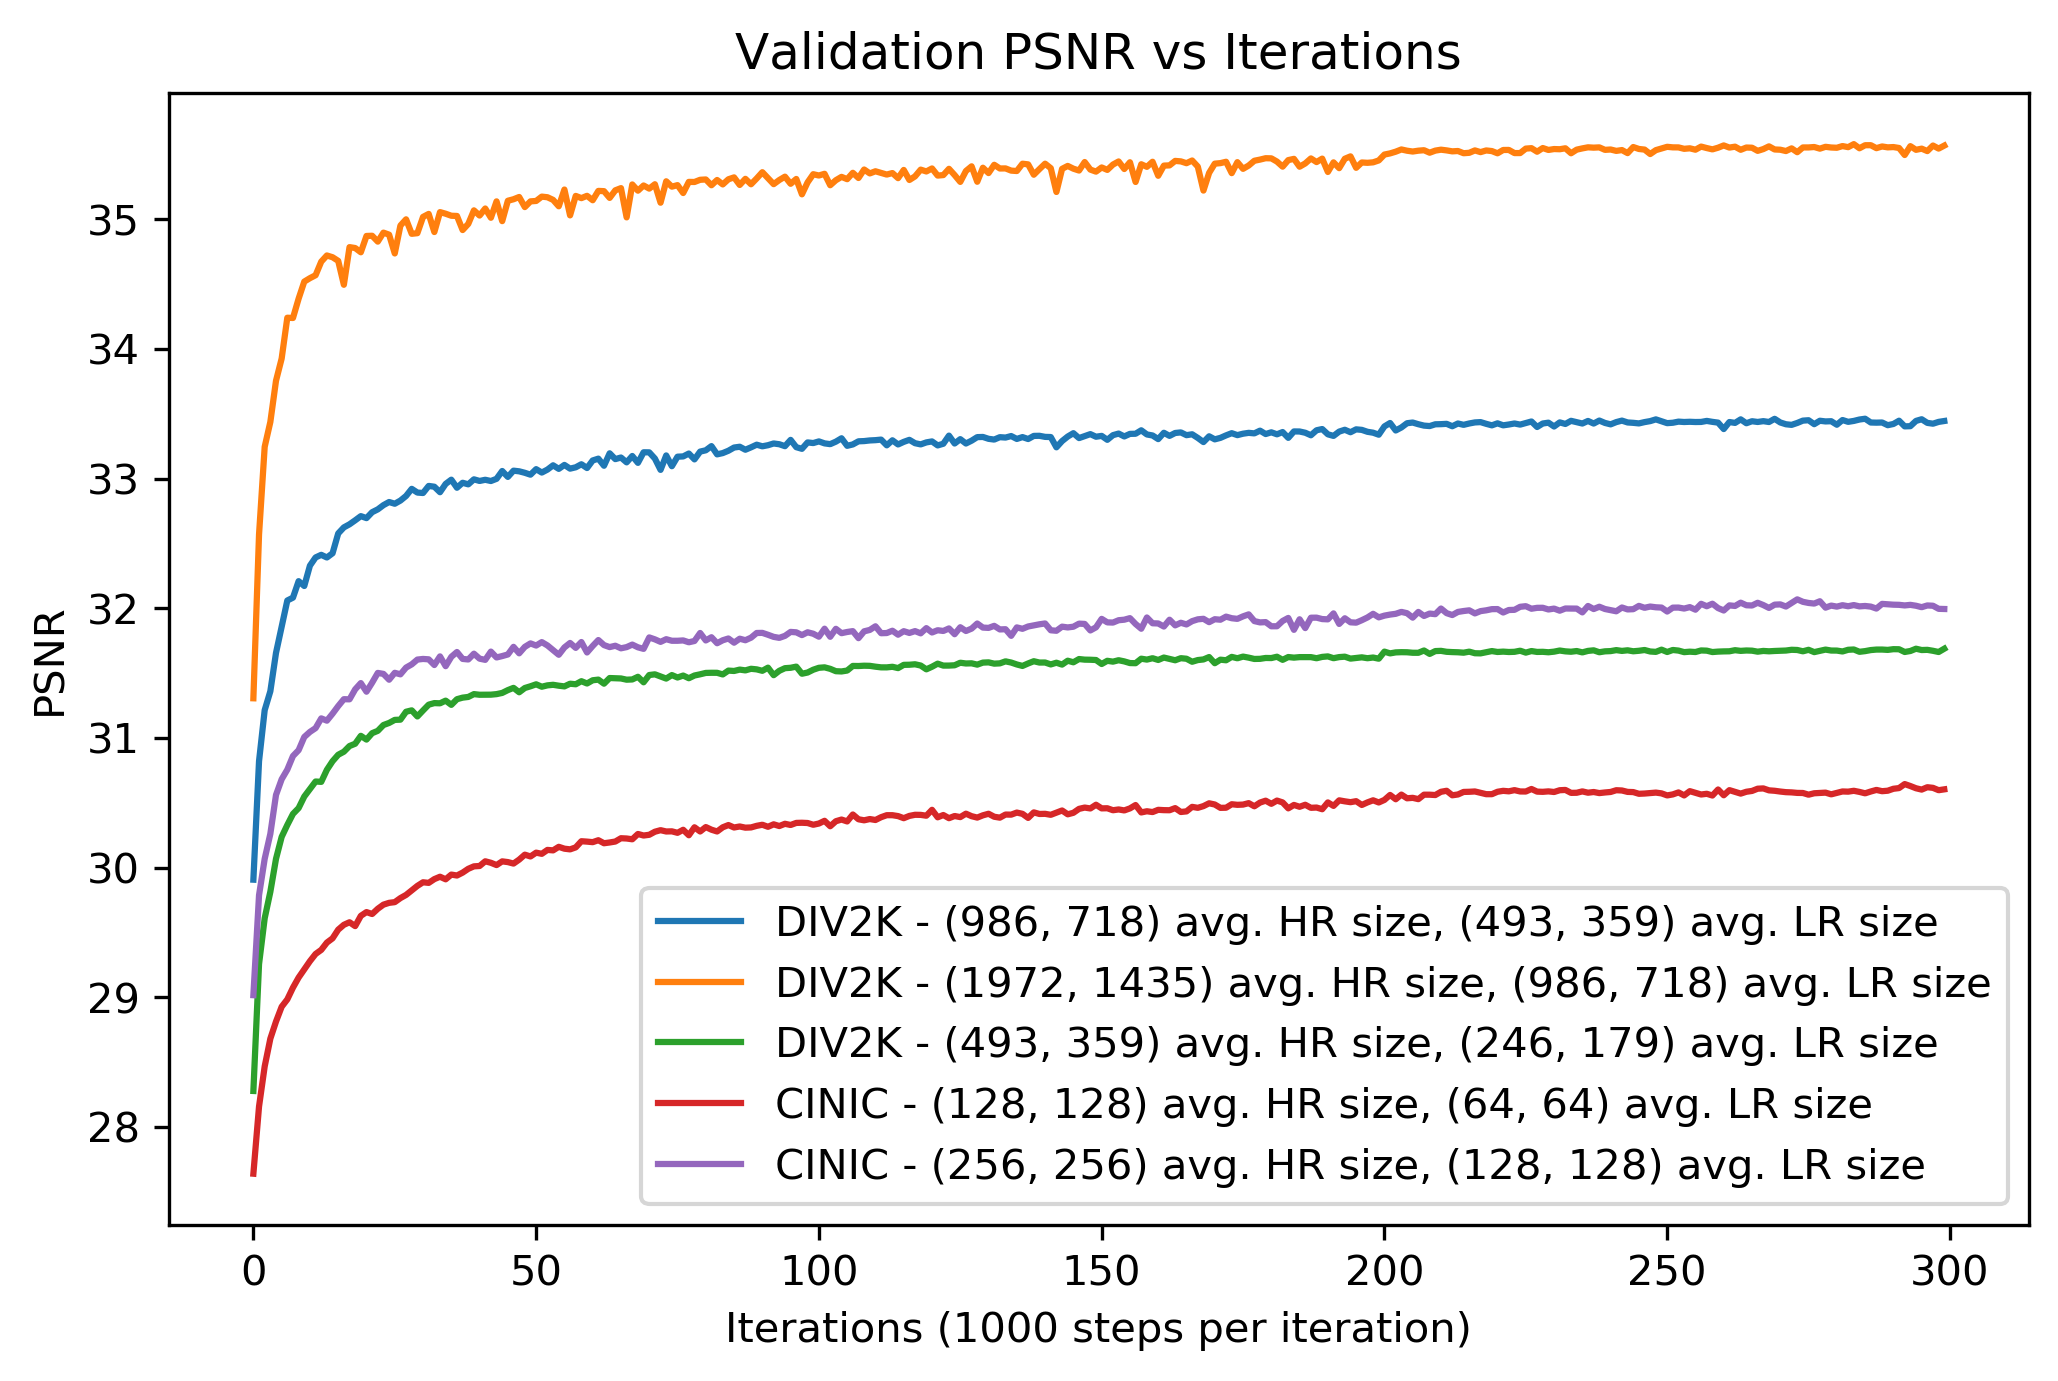

In [6]:
baseline_params = filter_params(all_params, dataset=["div2k", "cinic"], nb_res=16, nb_filt=64, sort="dataset", reverse=True)
plot(
    baseline_params,
    "losses",
    "baseline-loss.png",
    title="L$_1$ Loss vs Iterations",
    xlabel="Iterations (1000 steps per iteration)",
    ylabel="L$_1$ Loss"
)
plot(
    baseline_params,
    "psnr",
    "baseline-psnr.png",
    title="Validation PSNR vs Iterations",
    xlabel="Iterations (1000 steps per iteration)",
    ylabel="PSNR"
)
table(baseline_params)

## Tweaking Residual Blocks on CINIC

CINIC & (256, 256) & (128, 128) & 6.11 & 29.91 & 7.98 & 188163.00 \\
CINIC & (256, 256) & (128, 128) & 7.68 & 30.89 & 7.37 & 262019.00 \\
CINIC & (256, 256) & (128, 128) & 9.48 & 31.28 & 7.16 & 335875.00 \\
CINIC & (256, 256) & (128, 128) & 12.63 & 31.60 & 6.97 & 483587.00 \\
CINIC & (256, 256) & (128, 128) & 19.23 & 31.82 & 6.84 & 779011.00 \\
CINIC & (256, 256) & (128, 128) & 31.93 & 32.07 & 6.70 & 1369859.00 \\
CINIC & (256, 256) & (128, 128) & 57.25 & 32.22 & 6.53 & 2551555.00 \\
CINIC & (256, 256) & (128, 128) & 105.15 & 32.47 & 6.41 & 4914947.00 \\


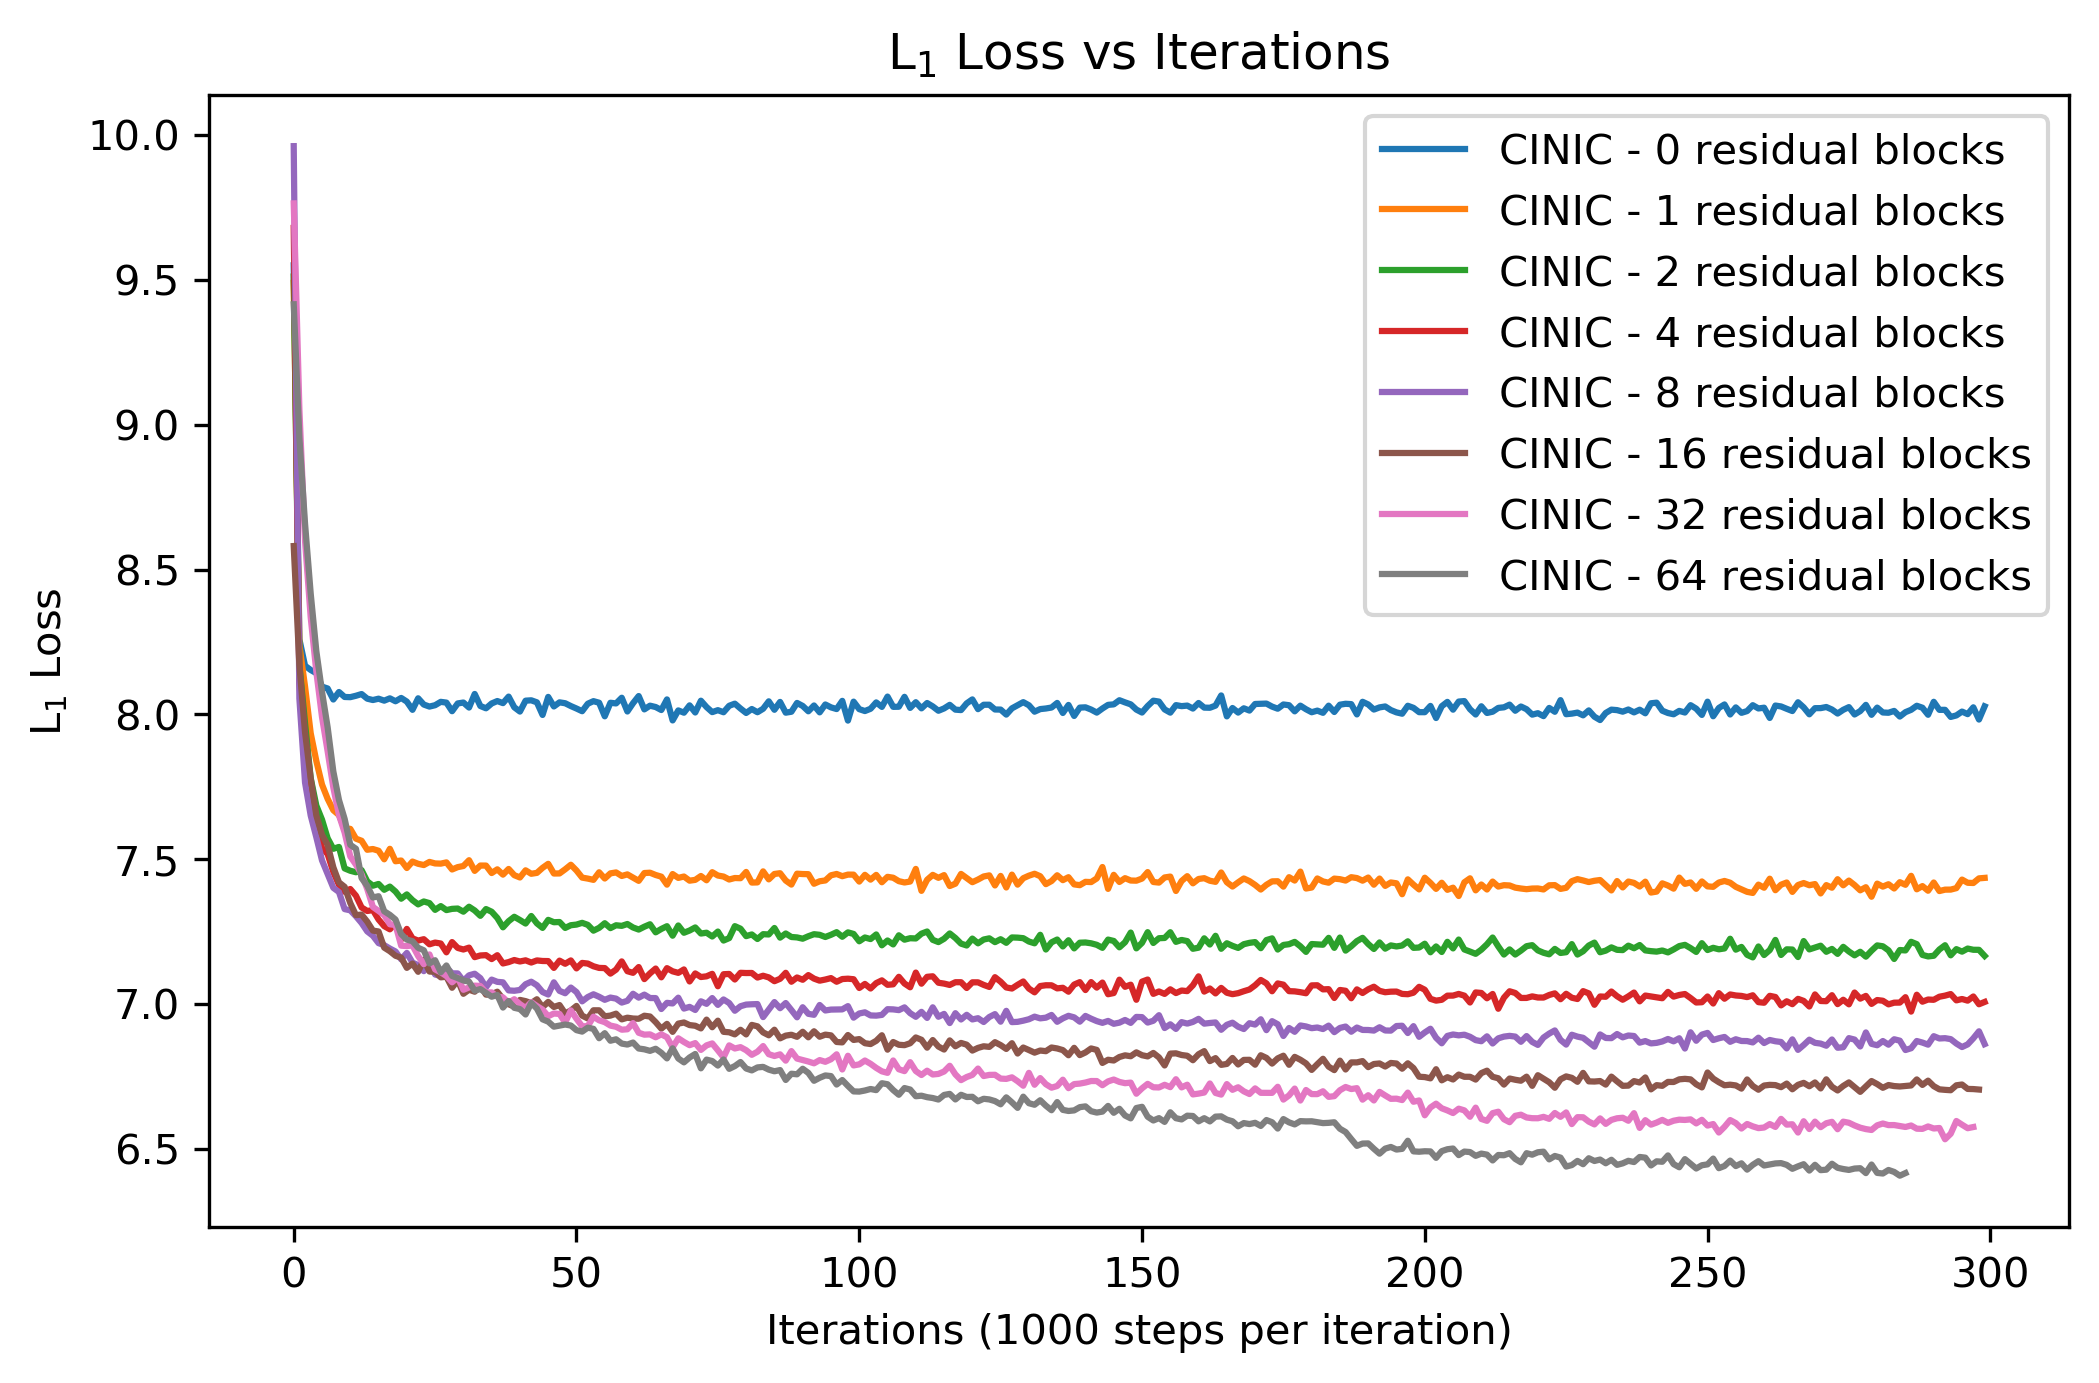

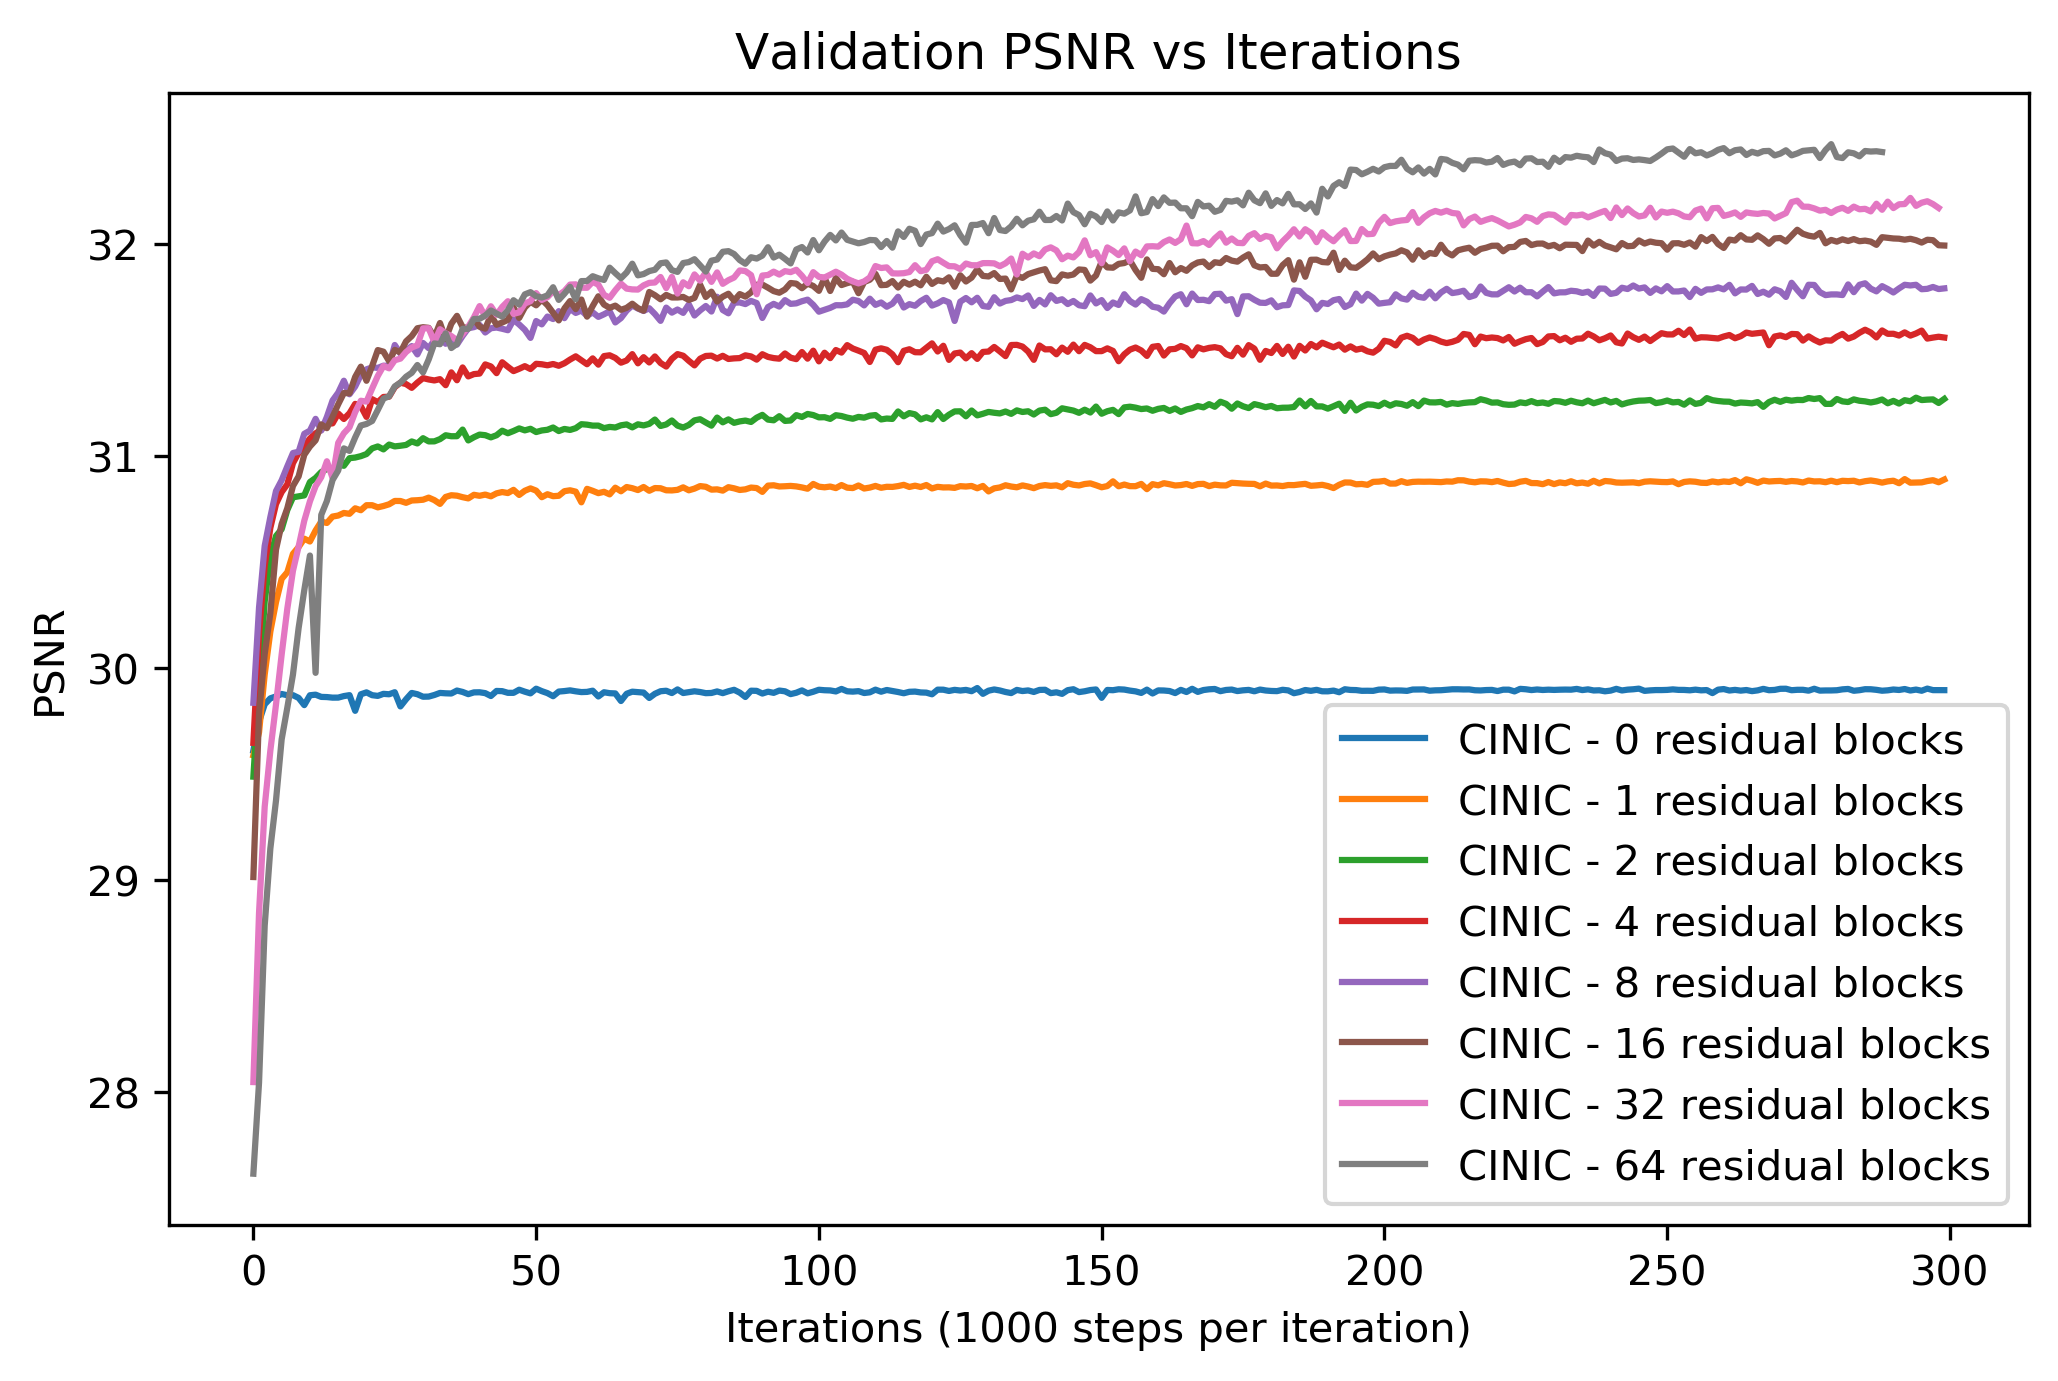

In [7]:
nb_res_params = filter_params(all_params, dataset="cinic", nb_filt=64, hr_scale=1, sort="nb_res")
plot(
    nb_res_params,
    "losses",
    "res-loss.png",
    title="L$_1$ Loss vs Iterations",
    xlabel="Iterations (1000 steps per iteration)",
    ylabel="L$_1$ Loss",
    label_type=["res"],
    upper=10
)
plot(
    nb_res_params,
    "psnr",
    "res-psnr.png",
    title="Validation PSNR vs Iterations",
    xlabel="Iterations (1000 steps per iteration)",
    ylabel="PSNR",
    label_type=["res"],
    lower=27
)
table(nb_res_params)

## Best Possible CINIC Network

CINIC & (256, 256) & (128, 128) & 150.96 & 33.52 & 5.59 & 21847043.00 \\
CINIC & (256, 256) & (128, 128) & 477.09 & 34.51 & 4.70 & 87341059.00 \\
CINIC & (256, 256) & (128, 128) & 881.86 & 33.93 & 5.08 & 162854915.00 \\


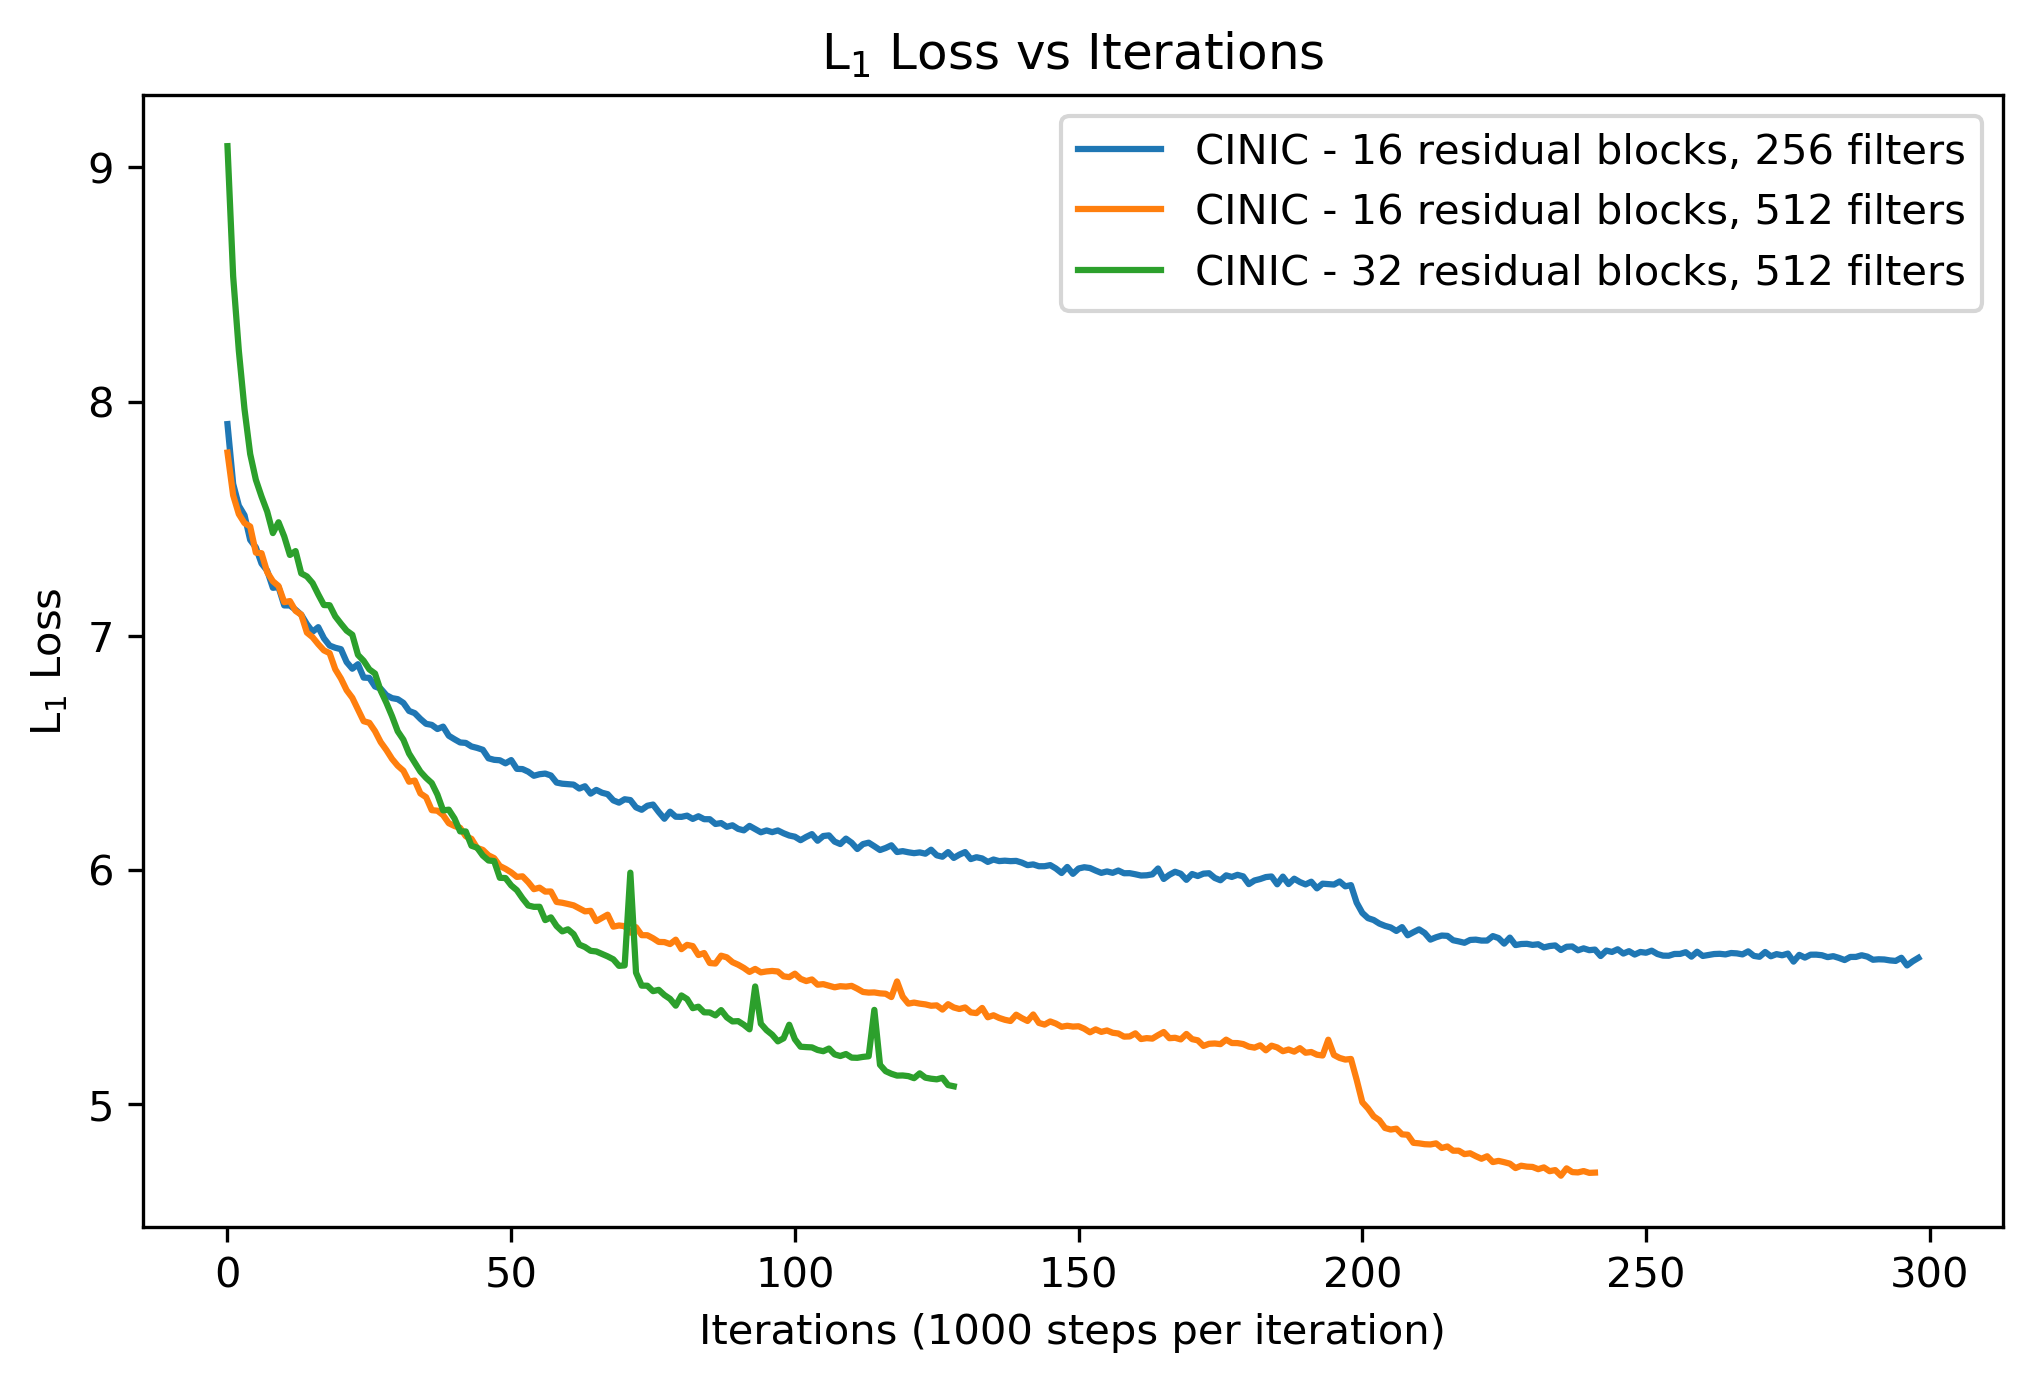

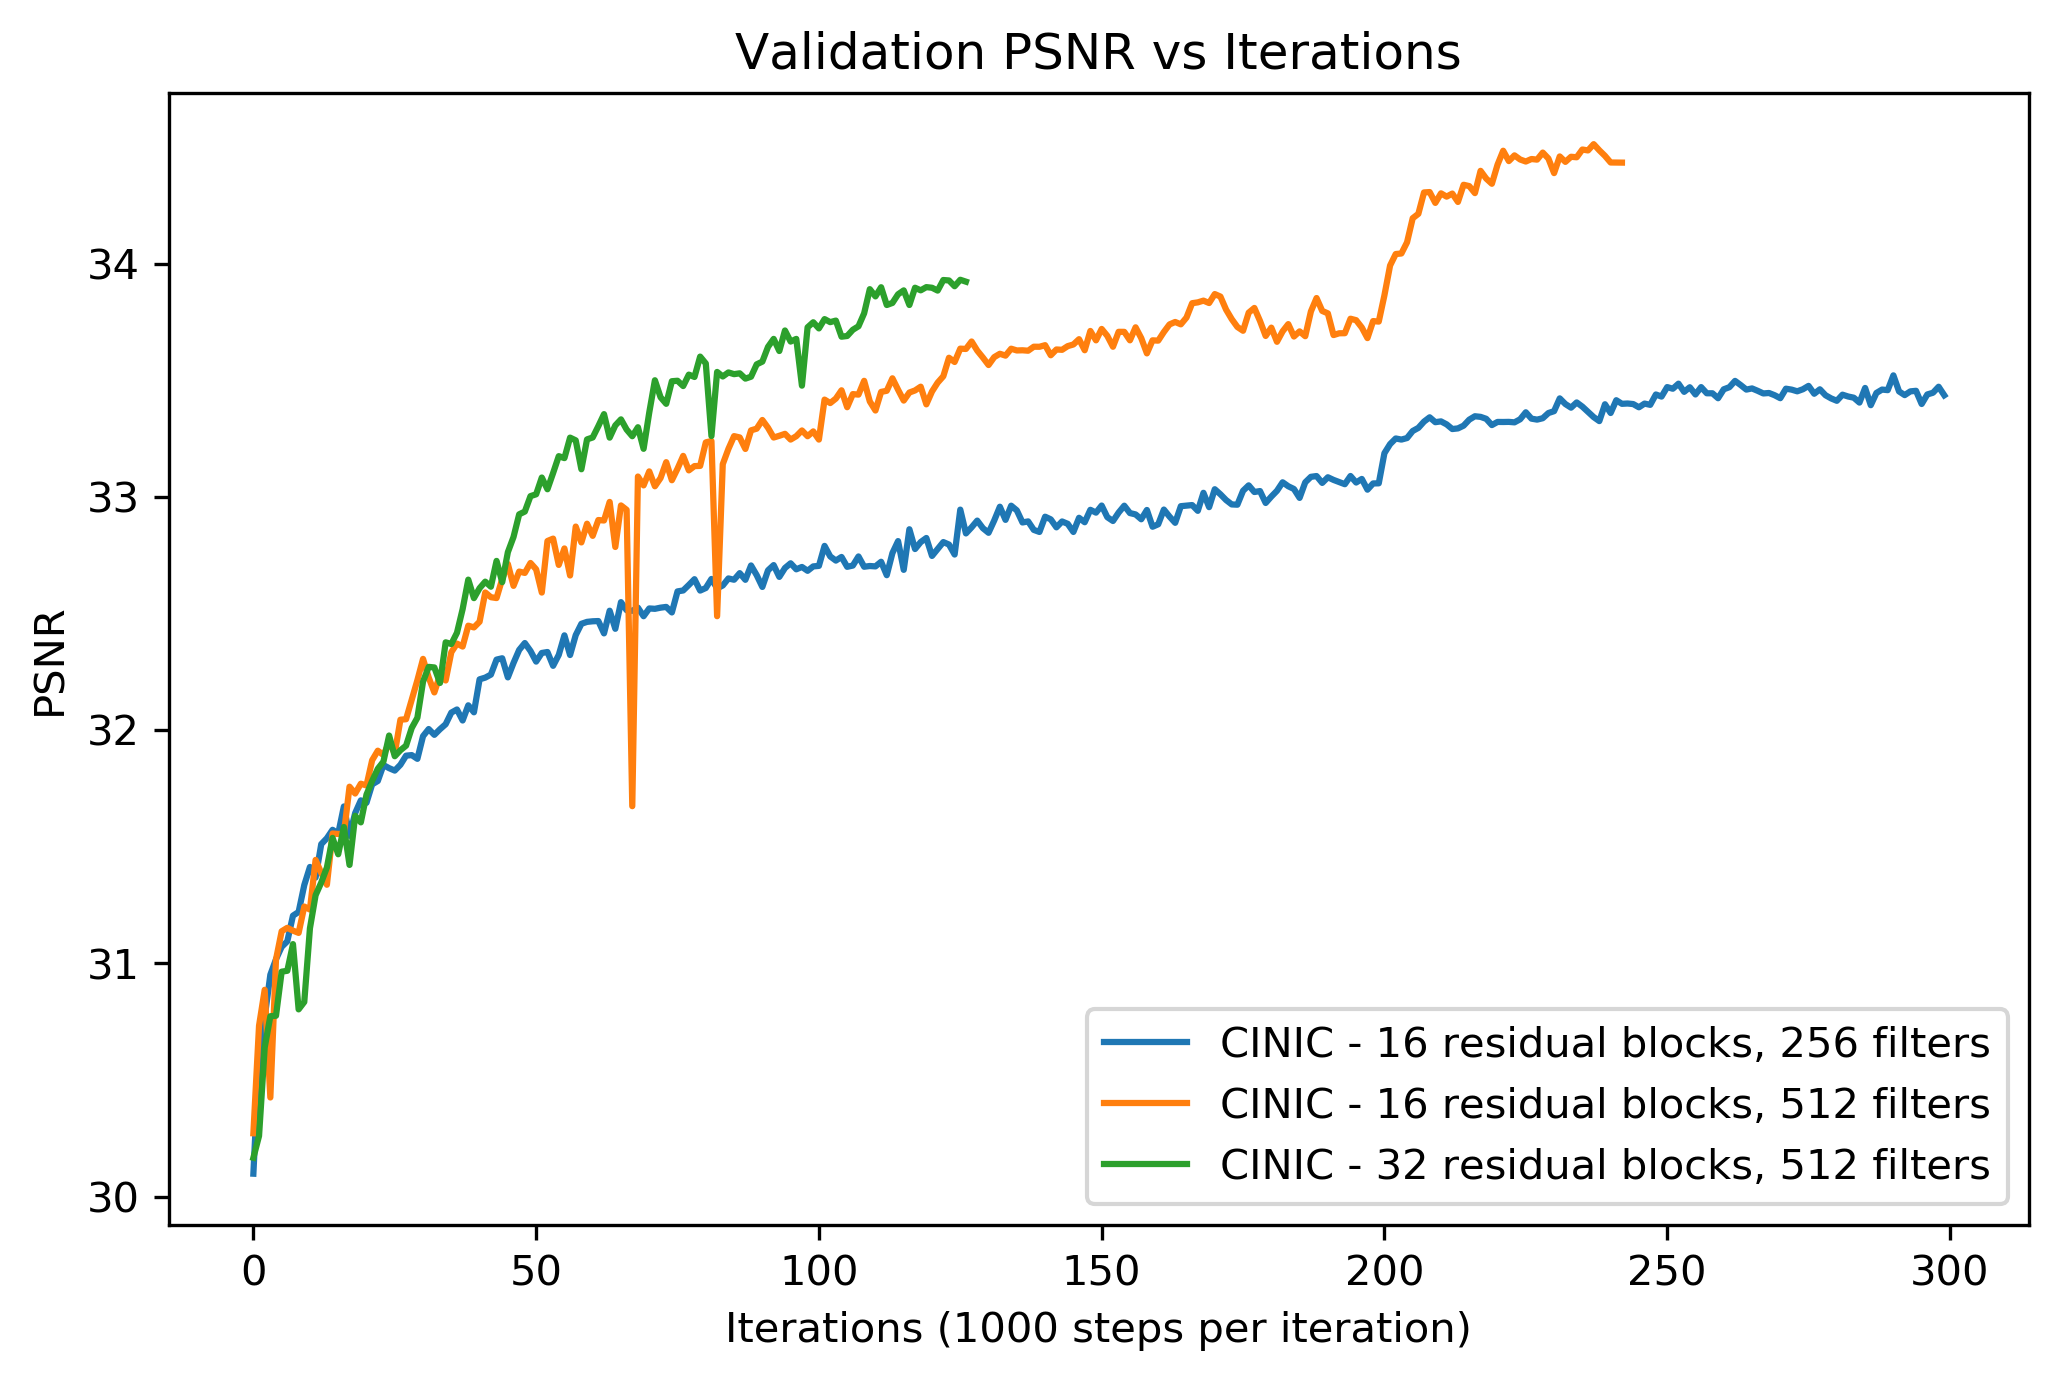

In [8]:
nb_filt_params = filter_params(all_params, dataset="cinic", nb_filt=[256, 512], sort="nb_filt")
plot(
    nb_filt_params,
    "losses",
    "filt-loss.png",
    title="L$_1$ Loss vs Iterations",
    xlabel="Iterations (1000 steps per iteration)",
    ylabel="L$_1$ Loss",
    label_type=["res", "filt"],
    upper=10
)
plot(
    nb_filt_params,
    "psnr",
    "filt-psnr.png",
    title="Validation PSNR vs Iterations",
    xlabel="Iterations (1000 steps per iteration)",
    ylabel="PSNR",
    label_type=["res", "filt"],
    lower=30
)
table(nb_filt_params)

## Smallest Possible CINIC Network

CINIC & (256, 256) & (128, 128) & 3.57 & 22.93 & 16.22 & 108.00 \\
CINIC & (256, 256) & (128, 128) & 3.59 & 28.35 & 9.93 & 303.00 \\
CINIC & (256, 256) & (128, 128) & 3.56 & 29.85 & 8.02 & 963.00 \\
CINIC & (256, 256) & (128, 128) & 3.54 & 29.90 & 7.98 & 12483.00 \\
CINIC & (256, 256) & (128, 128) & 6.11 & 29.91 & 7.98 & 188163.00 \\


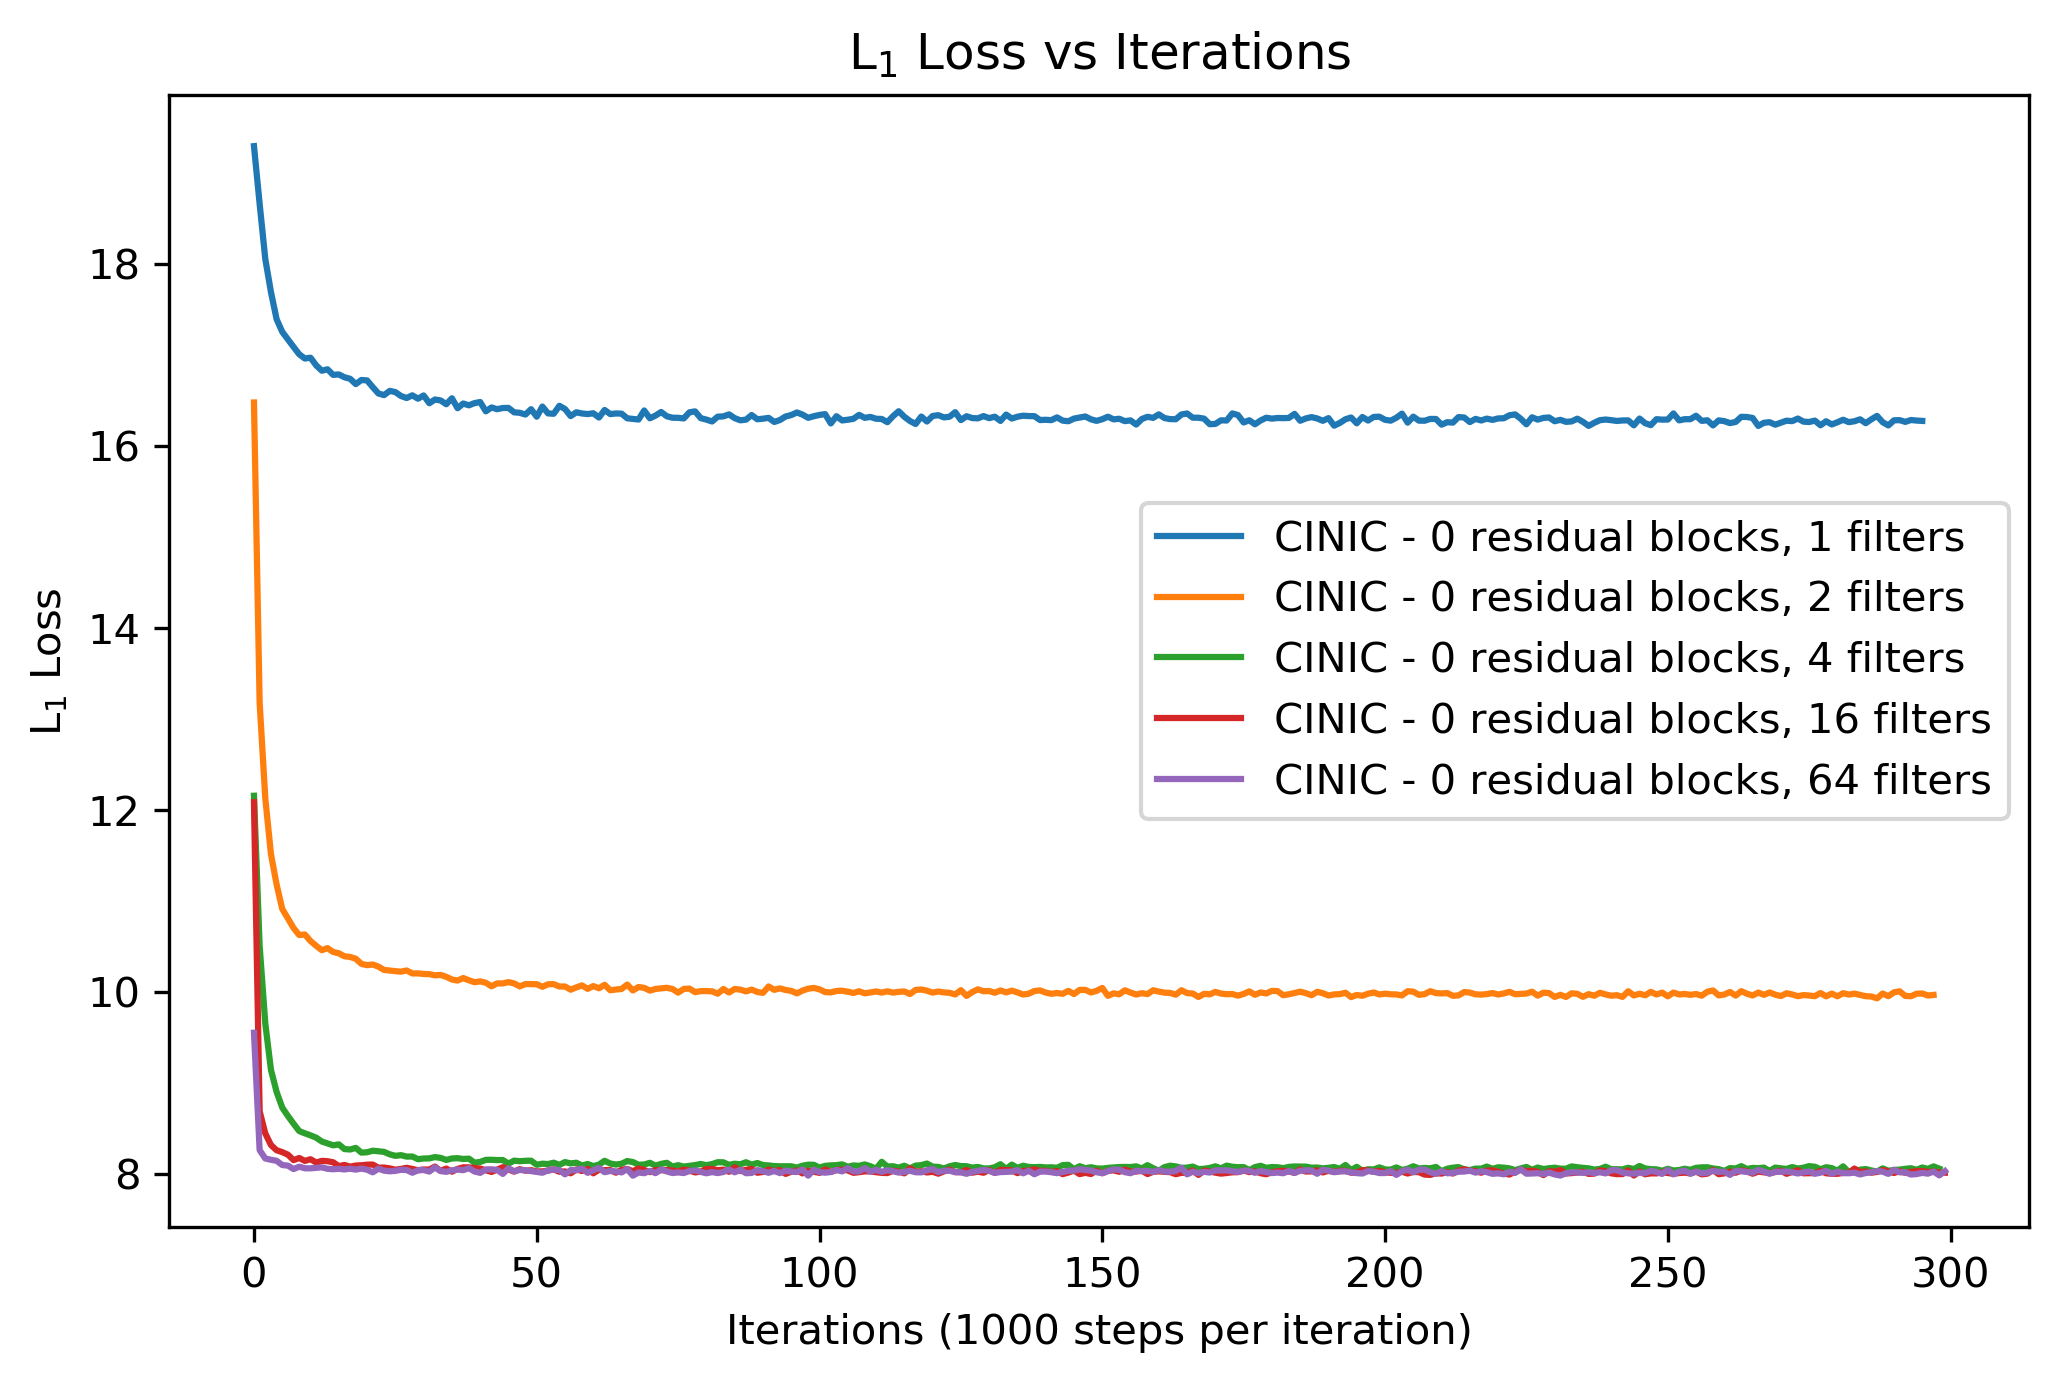

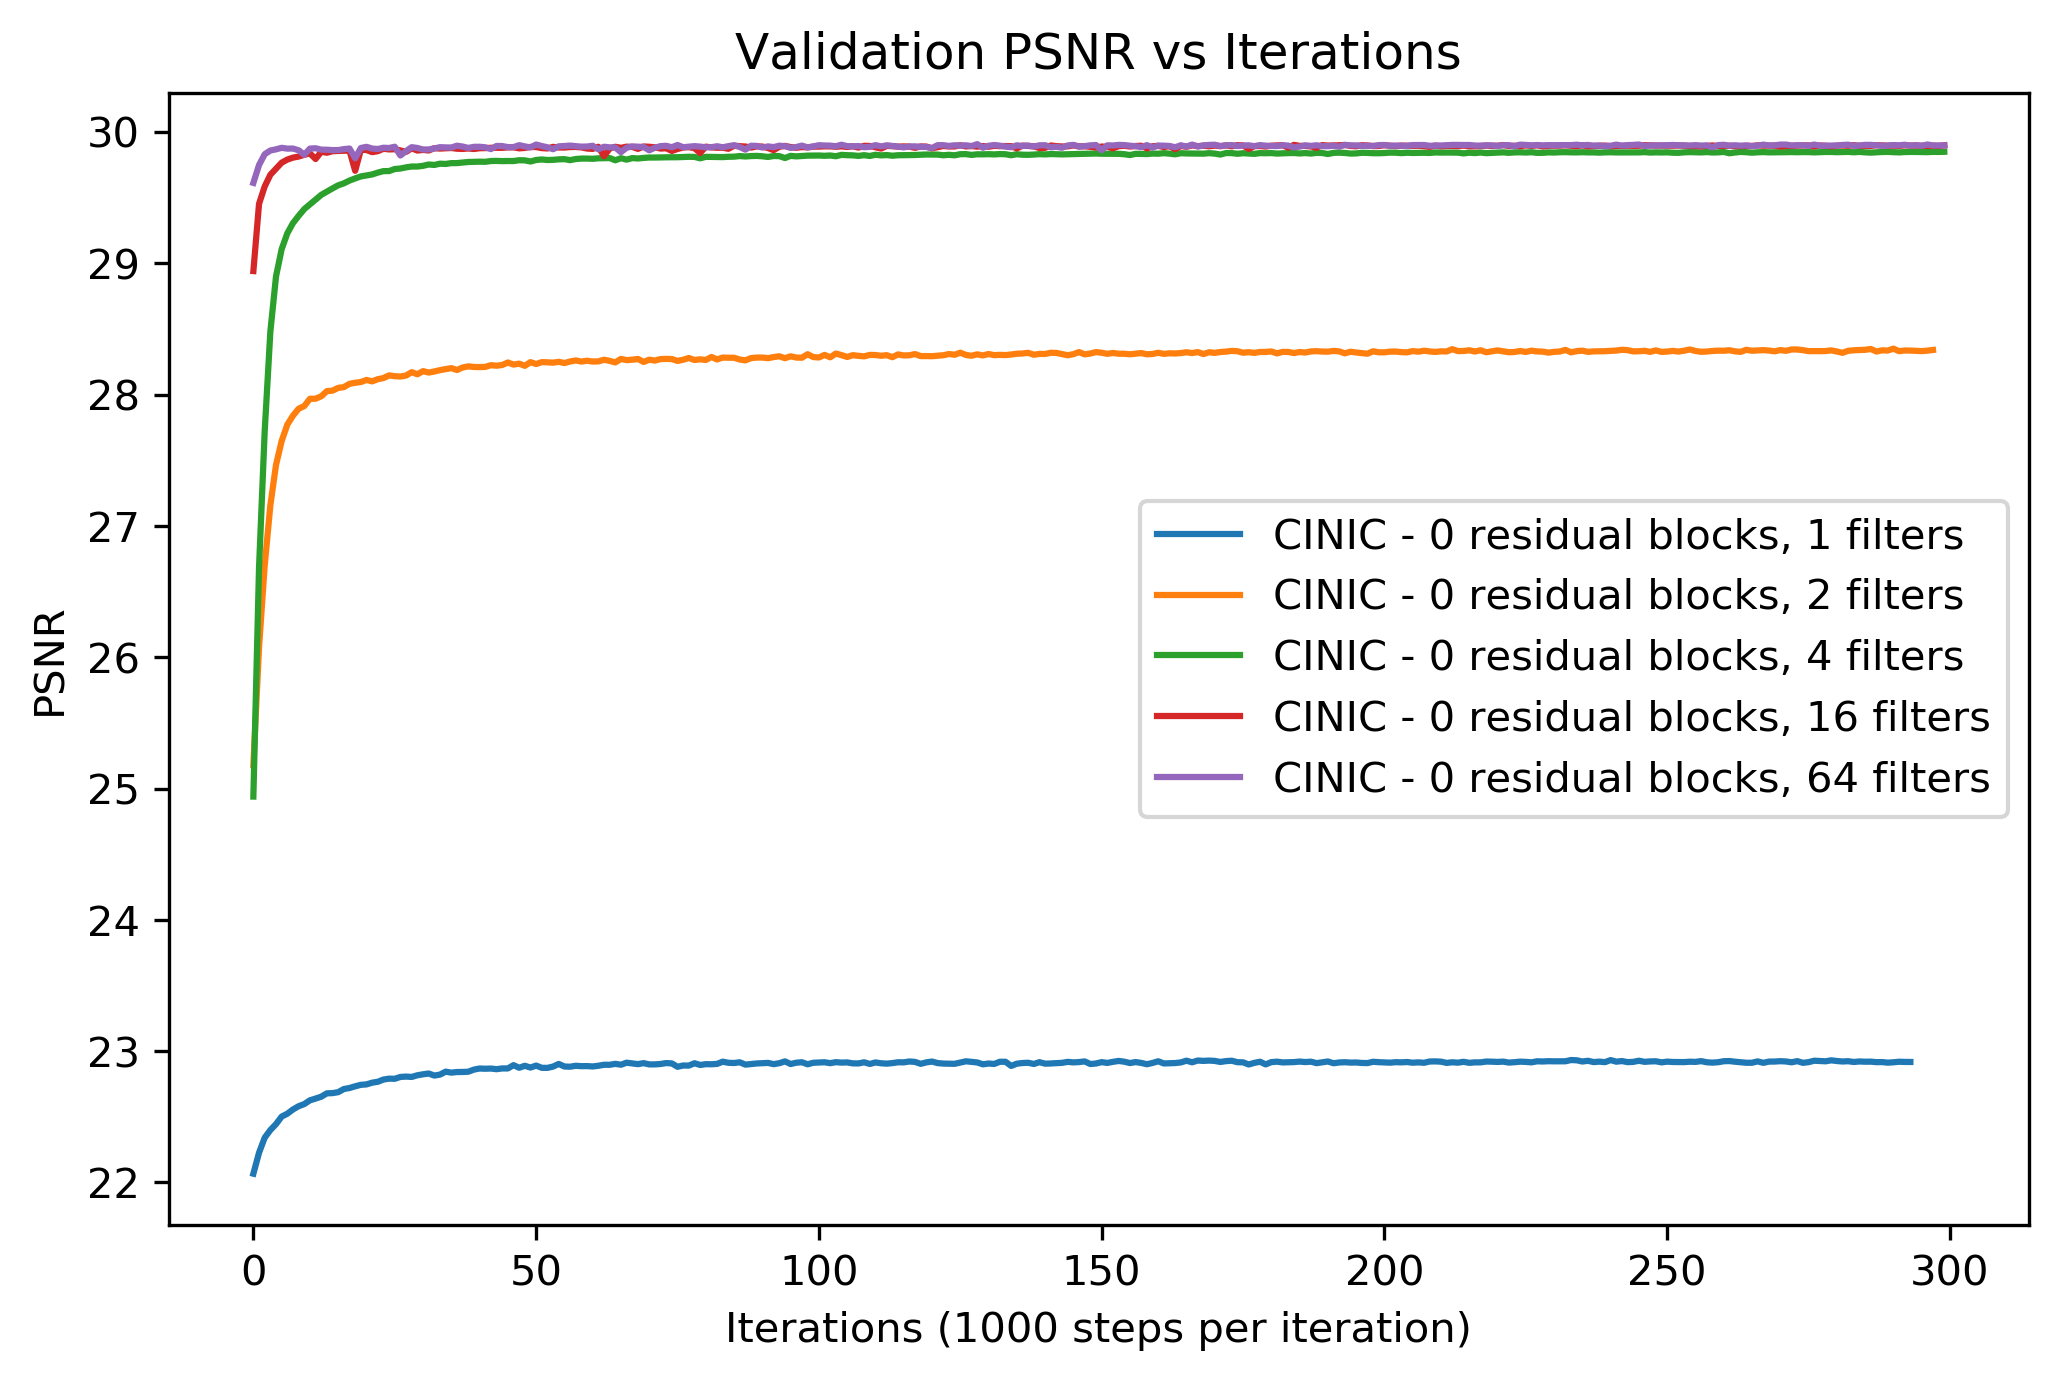

In [9]:
minimal_params = filter_params(all_params, dataset="cinic", nb_res=0, sort="nb_filt")
plot(
    minimal_params,
    "losses",
    "min-loss.png",
    title="L$_1$ Loss vs Iterations",
    xlabel="Iterations (1000 steps per iteration)",
    ylabel="L$_1$ Loss",
    label_type=["res", "filt"],
    upper=20
)
plot(
    minimal_params,
    "psnr",
    "min-psnr.png",
    title="Validation PSNR vs Iterations",
    xlabel="Iterations (1000 steps per iteration)",
    ylabel="PSNR",
    label_type=["res", "filt"],
    lower=22
)
table(minimal_params)